# QPU Execution

*What you will learn:*

- how the execution of a `Sequence` on a QPU differs from executing it on an emulator;
- how to execute a `Sequence` on a QPU;
- how to submit multiple jobs using a parametrized `Sequence`s.

## Introduction

When the time comes to execute a Pulser `Sequence`, there are many options: one can choose to execute it on a QPU or on an emulator, which might happen locally or remotely. All these options are accessible through a unified interface we call a `Backend`. 

**This tutorial is a step-by-step guide on how to use a QPU backend for Sequence execution.**

Since we recommend always testing on an emulator beforehand, please make sure you've followed the tutorial [Execution on an Emulator](backends.nblink) first.

## 1. Preparation for execution on  `QPUBackend`

`Sequence` execution on a QPU is done through the `QPUBackend`, which is a remote backend. Therefore, it requires a remote backend connection which should be created at the start due to two additional QPU constraints:

1. The `Device` must be compatible with the connection. Available devices can be found through `connection.fetch_available_devices()`.
2. If in the chosen device `Device.requires_layout` is `True`, the `Register` must be defined from a register layout:  
    -  If `Device.accepts_new_layouts` is `False`, use one of the register layouts calibrated for the chosen `Device` (found under `Device.calibrated_register_layouts`). Check out [this tutorial](reg_layouts.nblink) for more information on how to define a `Register` from a `RegisterLayout`.
    - Otherwise, we may choose to define our own custom layout or rely on `Register.with_automatic_layout()` to
    give us a register from an automatically generated register layout that fits our desired register while obeying the device constraints. 


Let us first create the `PasqalCloud` connection and use it to fetch the `FRESNEL_CAN1` `Device`.

<div class="alert alert-info">

Note that other connections than `PasqalCloud` exist. Some of the connections maintained by Pasqal are documented as part of the `pulser-pasqal` package [here](../apidoc/pasqal.rst).
</div>

In [1]:
from pulser_pasqal import PasqalCloud

connection = PasqalCloud(
    username=USERNAME,  # Your username or email address for the Pasqal Cloud Platform
    project_id=PROJECT_ID,  # The ID of the project associated to your account
    password=PASSWORD,  # The password for your Pasqal Cloud Platform account
)
print(connection.fetch_available_devices())
device = connection.fetch_available_devices()["FRESNEL_CAN1"]

{'FRESNEL_CAN1': FRESNEL_CAN1, 'FRESNEL': FRESNEL}


Now we can check what options we have for working with layouts. As documented in the tutorial on [hardware specifications](../hardware.ipynb), we can print the specs for the device. Doing this for `FRESNEL_CAN1` shows that it requires a layout, but it also allows us to define new layouts, which will allow us to just create the desired register from an automatic layout.

In [2]:
print(device.specs)


Register parameters:
 - Dimensions: 2D
 - Maximum number of atoms: 100
 - Maximum distance from origin: 46 µm
 - Minimum distance between neighbouring atoms: 5 μm

Layout parameters:
 - Requires layout: Yes
 - Accepts new layout: Yes
 - Minimal number of traps: 60
 - Maximal number of traps: 217
 - Minimum layout filling fraction: 0.35
 - Maximum layout filling fraction: 0.55

Device parameters:
 - Rydberg level: 60
 - Ising interaction coefficient: 865723.02
 - Channels can be reused: No
 - Supported bases: ground-rydberg
 - Supported states: r, g
 - SLM Mask: No
 - Maximum sequence duration: 6000 ns
 - Maximum number of runs: 1000
 - Default noise model: NoiseModel(noise_types=('SPAM', 'dephasing', 'relaxation'), state_prep_error=0.0, p_false_pos=0.025, p_false_neg=0.1, relaxation_rate=0.01, dephasing_rate=0.2222222222222222, hyperfine_dephasing_rate=0.0)

Channels:
 - 'rydberg_global': Rydberg(addressing='Global',
        max_abs_detuning=62.83185307179586,
        max_amp=12.56637

## 2. Creating the Pulse Sequence
Let's create the same sequence as in [Execution on an Emulator](backends.nblink). The one difference with before is the call to `Register.with_automatic_layout`. To show the effect of this, let's also draw the register, including the trap sites generated by the automatic layout. `FRESNEL_CAN1` also contains a precalibrated triangular lattice layout with a spacing of `5µm` which we equally could have used for our chosen register. Notice that the automatically generated layout is not the same as the precalibrated one: it is not quite triangular.

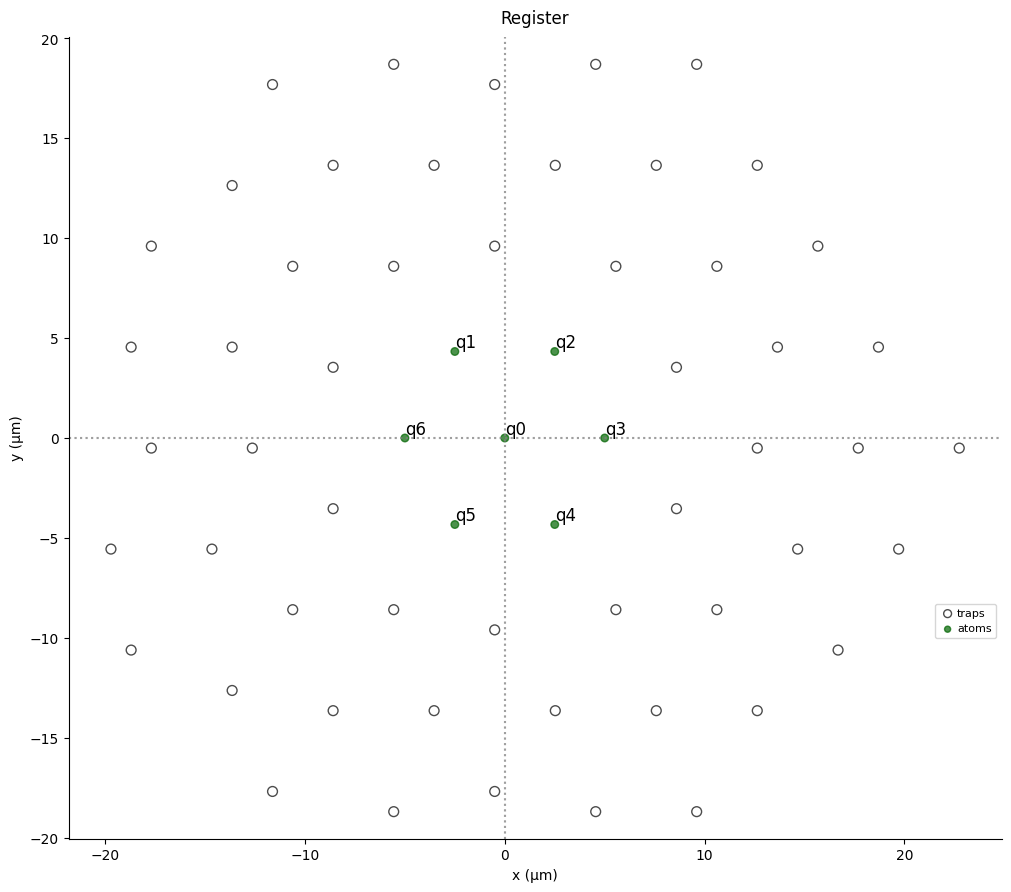

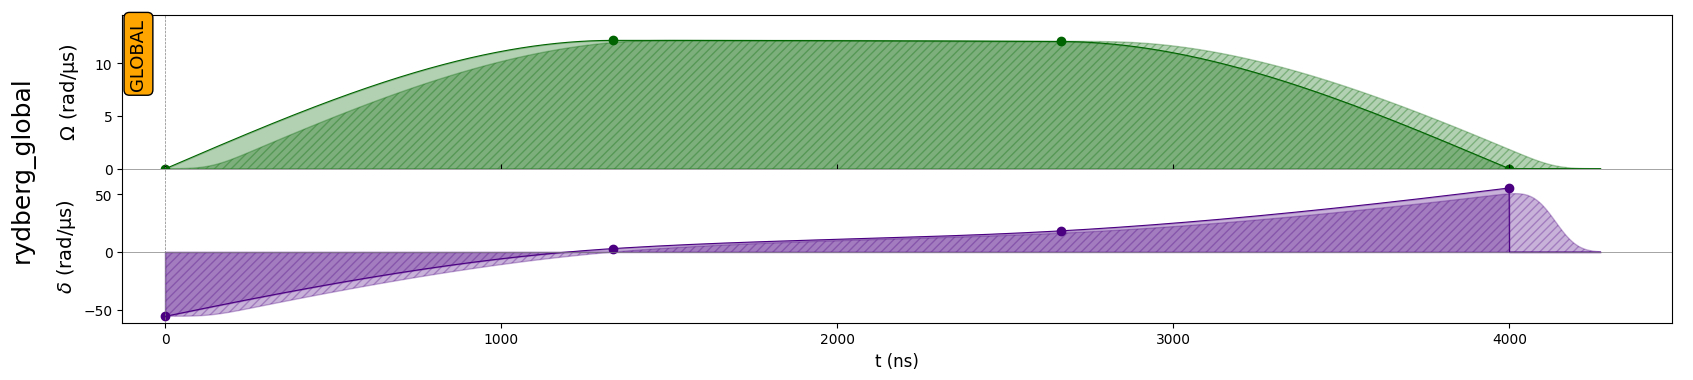

In [3]:
import numpy as np
import pulser

# 1. Picking a `Device`
# device = connection.fetch_available_devices()["FRESNEL_CAN1"]
# 2. Creating the Register
R_interatomic = 5  # um
bare_register = pulser.Register.hexagon(1, R_interatomic, prefix="q")
# Associating a layout to the Register
register = bare_register.with_automatic_layout(device)

seq = pulser.Sequence(register, device)

# 3. Picking the channels
seq.declare_channel("rydberg_global", "rydberg_global")

# 4. Adding the pulses

# Parameters in rad/µs
U = device.interaction_coeff / R_interatomic**6

# Time parameters
total_duration = 4000  # in ns
interp_pts = np.linspace(0, 1, 4)  # between 0 and 1

seq.add(
    pulser.Pulse(
        pulser.InterpolatedWaveform(
            total_duration,
            U * np.array([1e-9, 0.22, 0.2181, 1e-9]),
            times=interp_pts,
        ),
        pulser.InterpolatedWaveform(
            total_duration,
            U * np.array([-1, 0.0556, 0.332, 1]),
            times=interp_pts,
        ),
        0,
    ),
    "rydberg_global",
)

seq.draw(draw_register=True)

## 3. Running on a QPU

### 3.1. Executing on QPUBackend

Running the `Sequence` on a `QPU` is very similar to having an emulator run it. The `QPUBackend` automatically determines which QPU to run on from the `Device` specified in the `Sequence`. Consequently, we create a `QPUBackend` which, being a remote backend, will require the `Sequence` and the `Connection`. 

`QPUBackend` can take a configuration object to define the default number of shots to take for each job. Note that this value has an upper bound as specified by the `Device`. From the printed device specs above, we can see that the largest possible value is `1000` for `FRESNEL_CAN1`.

A single bitstring will be measured at the end of each run. More measurements per run are not possible since measuring bitstrings destroys the quantum state, and the sequence will have to be run again.


<div class="alert alert-info">

**Note**:

The number of times that the `Sequence` is run on the QPU can also be defined in the `run` method of `QPUBackend`, by providing `job_params`, a list of dictionnaries where the number of runs is defined under the key `runs`. See an example of a `run` exeuction with `job_params` [below](#4.-Batch-execution-with-parametrized-Sequences).
</div>

In [4]:
config = pulser.backend.BackendConfig(default_num_shots=1000)
backend = pulser.backends.QPUBackend(seq, connection, config=config)
results = backend.run()
print(f"Submitted batch {results.batch_id}")
BATCH_ID = results.batch_id

Submitted batch: b86a95be-e42c-4d36-b53f-0f09cd892abf


### 3.2. Restoring RemoteResults

It is quite frequent that one has to wait for the results to be available and interrupt the notebook in the mean time. This is not an issue! You can recreate the `RemoteResults` object associated to a batch anytime you want with the batch id (see `results.batch_id` above), by doing

In [5]:
results = pulser.backend.RemoteResults(
    BATCH_ID, connection  # ID of the submitted batch
)

### 3.3 Retrieving the Results

We can now print the results as they come in, just as for emulator backends.

In [6]:
print(results.get_batch_status())

results.get_available_results()

BatchStatus.DONE


{'798b18bd-5fab-4d7a-9d1c-4ae27201e36e': SampledResult(atom_order=('q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6'), meas_basis='ground-rydberg', bitstring_counts={'0010101': 321, '0101010': 310, '0010100': 22, '0100010': 21, '0101000': 20, '0000101': 19, '0111010': 16, '0010001': 14, '0100100': 13, '0011101': 13, '0010111': 13, '0001010': 12, '0101011': 12, '0110101': 10, '0010011': 10, '0110010': 9, '0101001': 9, '0011010': 8, '0010010': 8, '1010101': 7, '0011001': 6, '0101110': 6, '0100110': 6, '0010110': 6, '0001001': 6, '0110100': 6, '0001101': 5, '0100101': 5, '0110110': 4, '0001000': 4, '0101100': 4, '1101010': 4, '0111000': 3, '1100100': 3, '1000001': 3, '0000001': 2, '1100010': 2, '1100000': 2, '1010100': 2, '1001111': 2, '1000100': 2, '0111110': 2, '0111101': 2, '0110111': 2, '0110011': 2, '0101111': 2, '0101101': 2, '0100001': 2, '0011000': 2, '0010000': 2, '0001011': 2, '0000100': 2, '0011111': 1, '0011110': 1, '0111100': 1, '0011100': 1, '0011011': 1, '0111111': 1, '1000000': 1, 

The QPU only returns bitstrings at the final time, and as for emulator backends, there is a dedicated method for accessing them.

In [7]:
print(results[0].final_bitstrings)

Counter({'0010101': 321, '0101010': 310, '0010100': 22, '0100010': 21, '0101000': 20, '0000101': 19, '0111010': 16, '0010001': 14, '0100100': 13, '0011101': 13, '0010111': 13, '0001010': 12, '0101011': 12, '0110101': 10, '0010011': 10, '0110010': 9, '0101001': 9, '0011010': 8, '0010010': 8, '1010101': 7, '0011001': 6, '0101110': 6, '0100110': 6, '0010110': 6, '0001001': 6, '0110100': 6, '0001101': 5, '0100101': 5, '0110110': 4, '0001000': 4, '0101100': 4, '1101010': 4, '0111000': 3, '1100100': 3, '1000001': 3, '0000001': 2, '1100010': 2, '1100000': 2, '1010100': 2, '1001111': 2, '1000100': 2, '0111110': 2, '0111101': 2, '0110111': 2, '0110011': 2, '0101111': 2, '0101101': 2, '0100001': 2, '0011000': 2, '0010000': 2, '0001011': 2, '0000100': 2, '0011111': 1, '0011110': 1, '0111100': 1, '0011100': 1, '0011011': 1, '0111111': 1, '1000000': 1, '1111011': 1, '1000111': 1, '1001000': 1, '1001001': 1, '1001011': 1, '1010001': 1, '1010010': 1, '1010111': 1, '0000011': 1, '0001110': 1, '1011101

## 4. Batch execution with parametrized Sequences

<div class="alert alert-warning">

**Note**:

Parametrized Sequences are an extended usage feature. Read more about them [here](./paramseqs.nblink).

</div>

The `Sequence` we just executed on the QPU is composed of a single `Pulse` whose amplitude and detuning are each defined with an [InterpolatedWaveform](./interpolated_wfs.nblink). This makes it very easy to play with the duration of the `Sequence`. Let's see how to do this in practice. 

`QPUBackend` is instantiated with a Sequence. If you want to run an experiment in which you vary a parameter in your Sequence (like in this tutorial), you don't need to create a `QPUBackend` for each of the created Sequence: you can use a [parametrized Sequence](./paramseqs.nblink) to submit a batch of Sequences to the QPU. This will have the advantage to conveniently group the outcomes together. Specifically, this is possible for sequences composed of the same series of `Pulse`s, with the same `RegisterLayout` (a `Sequence` can be defined with a [MappableRegister](./reg_layouts.nblink) to define multiple `Sequences` from the same layout). 

Let us demonstrate how this works by taking the `Sequence` defined in section 2, and making the duration `t` a parameter. We will then submit two jobs in a single batch, using different values for `t`. The `Sequence` under study being an "adiabatic" state preparation, the quality of the preparation of the AFM state $\frac{1}{\sqrt{2}}\left(\left|grgrgrg\right> + \left|ggrgrgr\right>\right)$ should increase with the duration of the `Sequence` (you can see this by playing with the `total_duration` in the [tutorial on the execution on emulators](./backends.nblink)).

In [8]:
param_seq = pulser.Sequence(register, device)

# 3. Picking the channels
param_seq.declare_channel("rydberg_global", "rydberg_global")

# 4. Adding the pulses

t = param_seq.declare_variable("t", dtype=int)

param_seq.add(
    pulser.Pulse(
        pulser.InterpolatedWaveform(
            t, U * np.array([1e-9, 0.22, 0.2181, 1e-9]), times=interp_pts
        ),
        pulser.InterpolatedWaveform(
            t, U * np.array([-1, 0.0556, 0.332, 1]), times=interp_pts
        ),
        0,
    ),
    "rydberg_global",
)
print(param_seq)  # A parametrized Sequence cannot be drawn

Prelude
-------
Channel: rydberg_global
t: 0 | Initial targets: q0, q1, q2, q3, q4, q5, q6 | Phase Reference: 0.0 

Stored calls
------------

1. add(Pulse(InterpolatedWaveform(t[0], [5.54062733e-08 1.21893801e+01 1.20841082e+01 5.54062733e-08], times=[0.         0.33333333 0.66666667 1.        ]), InterpolatedWaveform(t[0], [-55.40627328   3.08058879  18.39488273  55.40627328], times=[0.         0.33333333 0.66666667 1.        ]), 0), rydberg_global)


We can now plot the sequence only after we specify a value for `t`. Let us put `t=4000` and show that the sequence is identical to that in section 2.

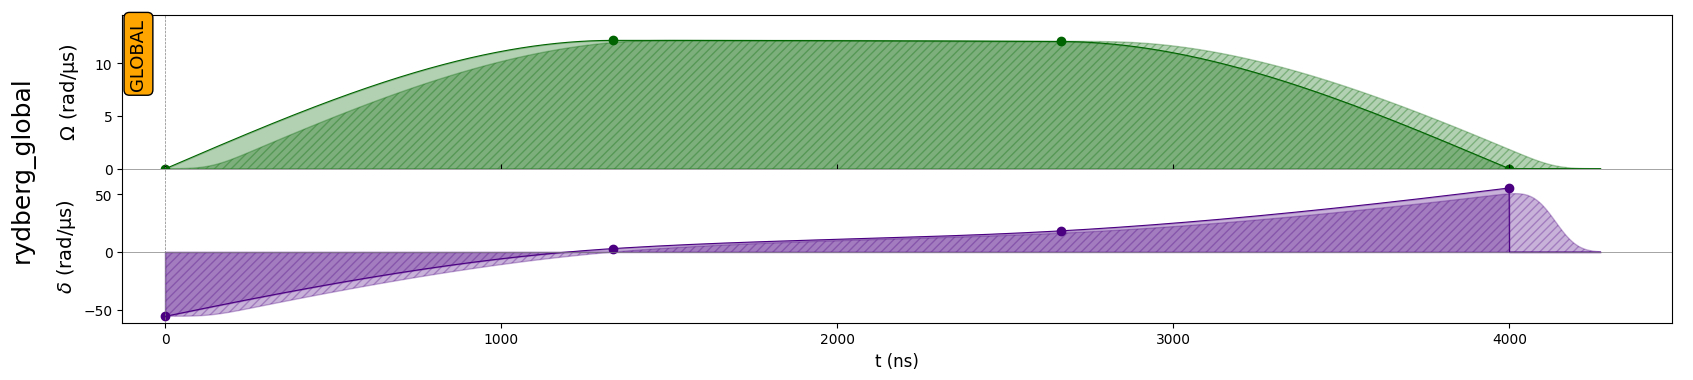

In [9]:
seq_4000 = param_seq.build(t=4000)
seq_4000.draw()

We can now submit jobs with different values of `t` by leveraging the `job_params` argument of `QPUBackend.run`. However, to do that we must first create a new `QPUBackend` with the parameterized sequence.

A job will be created for each dictionnary provided in `job_params`. For each of these jobs:
- the value of each parameter in the `Sequence` must be provided under the `variables` key.
- the number of `runs` is by default `config.default_num_shots`, but it can be specified under the `runs` key.

In [10]:
config = pulser.backend.BackendConfig(default_num_shots=1000)
param_backend = pulser.backends.QPUBackend(
    param_seq, connection, config=config
)
param_job_params = [
    {"variables": {"t": 300}},  # uses config.default_num_shots
    {"runs": 1000, "variables": {"t": 1000}},  # uses 1000 shots
    {"variables": {"t": 4000}},  # uses config.default_num_shots
]
param_results = param_backend.run(job_params=param_job_params)
print(f"Submitted batch {param_results.batch_id}")
print(f"With job IDs {param_results.job_ids}")

Submitted batch f2a752b3-87ef-4ee4-ac75-eee04f32eb5b
With job IDs ['ce8a5be0-2565-463a-885b-54ade900be26', 'f3c78b1d-e3f3-4bfb-b2f7-7db30e3441e4', '4e754800-1c3c-4f68-b943-47a65ab913be']


Once again, we can see the results as they come in. Note that since we now specify 3 jobs in the `job_params` we expect 3 results in total.

In [11]:
param_results.get_available_results()

{'ce8a5be0-2565-463a-885b-54ade900be26': SampledResult(atom_order=('q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6'), meas_basis='ground-rydberg', bitstring_counts=Counter({'0000000': 827, '0000100': 35, '0000001': 28, '0010000': 22, '0100000': 21, '0001000': 19, '0000010': 16, '1000000': 9, '1000100': 3, '0000101': 2, '0011000': 2, '0001101': 1, '0001010': 1, '0001001': 1, '0000110': 1, '0000011': 1, '0010010': 1, '1001110': 1, '1001000': 1, '0110000': 1, '0101000': 1, '0100100': 1, '0100010': 1, '0100001': 1, '0010100': 1, '1010000': 1, '0010001': 1}), evaluation_time=1.0), 'f3c78b1d-e3f3-4bfb-b2f7-7db30e3441e4': SampledResult(atom_order=('q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6'), meas_basis='ground-rydberg', bitstring_counts=Counter({'0101010': 161, '0010101': 158, '0000101': 67, '0010100': 61, '0100010': 60, '0101000': 50, '0010001': 50, '0001010': 44, '0000010': 31, '0001000': 29, '0000100': 26, '0010010': 22, '0000001': 22, '0001001': 22, '0100100': 22, '0100000': 20, '0010000': 19, '100

We can once again print the final bitstrings. We see that the longer the Sequence the closer the final state is to the antiferromagnetic state $\frac{1}{\sqrt{2}}\left(\left|ggrgrgr\right>+\left|grgrgrg\right>\right)$ ($\left|ggrgrgr\right>$ is measured as $\left|0010101\right>$, $\left|grgrgrg\right>$ is measured as $\left|0101010\right>$, [see the Convention page](../conventions.md)), as expected of an adiabatic state preparation.

In [12]:
print("t=300:", param_results[0].final_bitstrings)
print("t=1000:", param_results[1].final_bitstrings)
print("t=4000:", param_results[2].final_bitstrings)

t=300ns: Counter({'0000000': 827, '0000100': 35, '0000001': 28, '0010000': 22, '0100000': 21, '0001000': 19, '0000010': 16, '1000000': 9, '1000100': 3, '0000101': 2, '0011000': 2, '0001101': 1, '0001010': 1, '0001001': 1, '0000110': 1, '0000011': 1, '0010010': 1, '1001110': 1, '1001000': 1, '0110000': 1, '0101000': 1, '0100100': 1, '0100010': 1, '0100001': 1, '0010100': 1, '1010000': 1, '0010001': 1})
t=1000ns: Counter({'0101010': 161, '0010101': 158, '0000101': 67, '0010100': 61, '0100010': 60, '0101000': 50, '0010001': 50, '0001010': 44, '0000010': 31, '0001000': 29, '0000100': 26, '0010010': 22, '0000001': 22, '0001001': 22, '0100100': 22, '0100000': 20, '0010000': 19, '1000000': 13, '0111010': 10, '0101011': 8, '0011101': 6, '0000000': 6, '0001101': 6, '0010011': 5, '0011010': 4, '0010111': 4, '0001100': 4, '0110000': 3, '0110010': 3, '0100110': 3, '0100101': 3, '0110100': 3, '0111000': 3, '0010110': 3, '1000100': 3, '0000011': 3, '0101100': 3, '1010101': 2, '0110001': 2, '0011100'

<div class="alert alert-info">

**To go further**:

The pulse used in this `Sequence` with two `InterpolatedWaveform`s for the amplitude and detuning was optimized to prepare AFM states. To get more information about how to use parameters to design a `Sequence` that best fits a certain criterion, please see the tutorial on [optimal control](./optimization.nblink).
</div>